In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qcsys as qs
import jax.numpy as jnp

/opt/miniconda3/envs/jax-framework/lib/python3.9/site-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


# Helpers

In [43]:
""" ATS Exploration Helpers. """


from jax import jit
from jax import config
import jax.numpy as jnp
import matplotlib.pyplot as plt 
import numpy as np



config.update("jax_enable_x64", True)
jnp.set_printoptions(linewidth=jnp.inf)

import qcsys as qs

@jit
def calc_ats_spectrum(ats_old, phi_delta_ext, phi_sum_ext):
    ats_new = qs.ATS.create(
        20, 
        {
            "Ec": ats_old.params["Ec"], 
            "El": ats_old.params["El"], 
            "Ej": ats_old.params["Ej"], 
            "Ej2":ats_old.params["Ej2"], 
            "dEj":ats_old.params["dEj"] , 
            "phi_delta_ext": phi_delta_ext, 
            "phi_sum_ext": phi_sum_ext},
            use_linear=False
    )

    devices = [ats_new]
    system = qs.System.create(devices, couplings=[])

    Es, kets = system.calculate_eig_linear()

    return Es, kets, ats_new

@jit
def calc_ats_storage_spectrum(ats_old, resonator, ϕ0, phi_delta_ext, phi_sum_ext):
    ats_new = qs.ATS.create(
        20, 
        {
            "Ec": ats_old.params["Ec"], 
            "El": ats_old.params["El"], 
            "Ej": ats_old.params["Ej"], 
            "Ej2":ats_old.params["Ej2"], 
            "dEj":ats_old.params/["dEj"] , 
            "phi_delta_ext": phi_delta_ext, 
            "phi_sum_ext": phi_sum_ext},
            use_linear=False
    )

    devices = [resonator, ats_new]
    Ns = [device.N for device in devices]

    r_indx = 0
    b_indx = 1

    dEj = ats_new.params["dEj"]
    Ej2 = ats_new.params["Ej2"]

    id_op_b = qs.promote(ats_new.ops["id"], b_indx, Ns)
    phi_delta_ext_op = phi_delta_ext * id_op_b 
    phi_b = qs.promote(ats_new.ops["phi"], b_indx, Ns)

    a0 = qs.promote(resonator.ops["a"], r_indx, Ns)
    a0_dag = qs.promote(resonator.ops["a_dag"], r_indx, Ns)
    phi_a = ϕ0["ATS0"]["Resonator0"] * (a0 + a0_dag)

    phi = phi_a + phi_b

    gen_ats_term = lambda x : (
            2 * dEj * qs.sinm(x +  2 * jnp.pi * phi_delta_ext_op) * jnp.sin(2 * jnp.pi * phi_sum_ext) +
            2 * Ej2 * qs.cosm(2*x + 2 * 2 * jnp.pi * phi_delta_ext_op) * jnp.cos(2 * 2 * jnp.pi * phi_sum_ext)
        )

    coupling_term += gen_ats_term(phi)
    coupling_term -= gen_ats_term(phi_b)

    system = qs.System.create(devices, couplings=[])

    Es, kets = system.calculate_eig_linear()

    return Es, kets, ats_new

def calc_ats_spectrum_grid(ats, phi_delta_exts, phi_sum_exts):
    x = phi_delta_exts
    y = phi_sum_exts
    xv, yv = jnp.meshgrid(x, y, indexing='xy')

    Es = np.zeros((len(y), len(x))) * np.nan
    for i in range(len(x)):
        for j in range(len(y)):
            Es_curr = calc_ats_spectrum(ats, xv[j,i], yv[j,i])[0]
            Es[j,i] = Es_curr[1] - Es_curr[0]
    return xv, yv, Es


def plot_ats_spectrum_grid(xv, yv, Es, vmax=None, vmin=None, cmap="viridis", ptype="contour"):
    fig, axs = plt.subplots(1, 1, figsize=(4, 3), dpi=200, squeeze=False)
    
    ax = axs[0][0]
    im = getattr(ax, ptype)(xv, yv, Es, cmap=cmap, vmax=vmax, vmin=vmin) # , vmin=0, vmax=1000)
    ax.set_xlabel("$\\Phi_{\\Delta}/ \\Phi_0$")
    ax.set_ylabel("$\\Phi_{\\Sigma}/ \\Phi_0$")
    fig.colorbar(im, orientation='vertical')
    fig.tight_layout()

    return axs

def calc_ats_spectrum_line(ats, sweep_vals, other_flux_fixed_point, sweep_delta=True):
    Es = []
    for sweep_val in sweep_vals:
        if sweep_delta:
            Es_curr, _, _ = calc_ats_spectrum(ats, sweep_val, other_flux_fixed_point)
        else:
            Es_curr, _, _ = calc_ats_spectrum(ats, other_flux_fixed_point, sweep_val)
        Es.append(Es_curr)

    Es = jnp.array(Es)
    return Es

def plot_ats_spectrum_line(Es, sweep_vals, xlim=None, ylim=None, sweep_delta=False):
    fig, axs = plt.subplots(2,1, figsize=(4,4), dpi=200, squeeze=False)

    if sweep_delta:
        sweep_label = "$\\Phi_{\\Delta}/\\Phi_{0}$"
    else:
        sweep_label = "$\\Phi_{\\Sigma}/\\Phi_{0}$"

    ax = axs[0][0]
    Es_plot = Es
    ax.plot(sweep_vals, Es_plot)
    ax.set_xlabel(sweep_label)
    ax.set_ylabel("$E$ [GHz]")
    ax.set_xlim(xlim)

    
    ax = axs[1][0]
    Es_plot = Es[:,:] - Es[:, 0].reshape(Es.shape[0], 1)
    ax.plot(sweep_vals, Es_plot)
    ax.set_xlabel(sweep_label)
    ax.set_ylabel("$E - E_g$ [GHz]")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)

    fig.tight_layout()

    return axs

# Analysis

In [90]:
ats = qs.ATS.create(
    20, 
    {
        "Ec": 72.6e-3, 
        "El": 62.40, 
        "Ej": 37, 
        "Ej2": 0, 
        "dEj": 0.207, 
        "phi_delta_ext": 0, 
        "phi_sum_ext": 0
    },
    use_linear=False
)

### Line Cuts

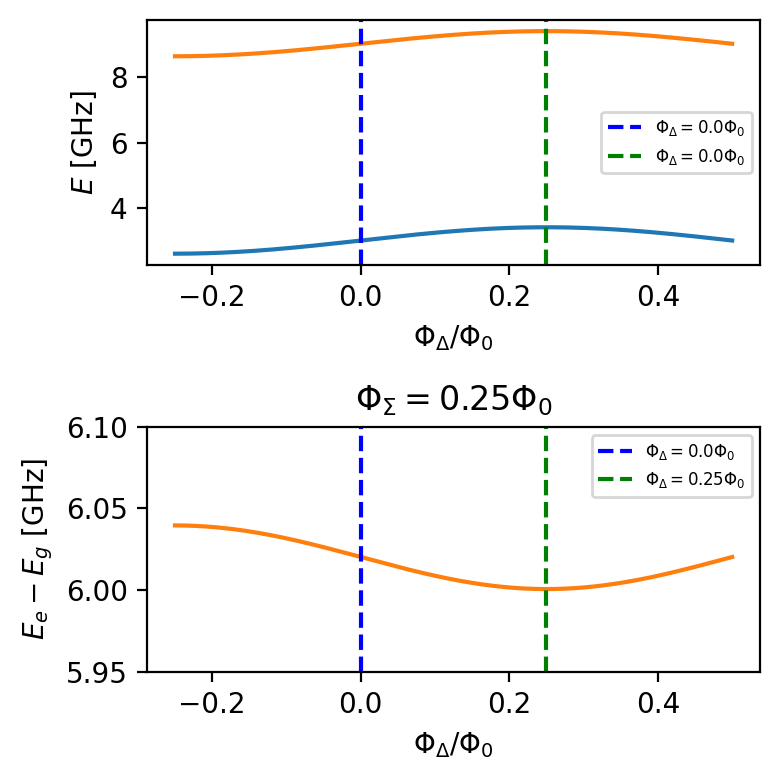

In [91]:
sweep_vals = jnp.linspace(-0.25,0.5, 1001)
Es = calc_ats_spectrum_line(ats, sweep_vals, 0.25, sweep_delta=True)[:,:2]
axs = plot_ats_spectrum_line(Es, sweep_vals, sweep_delta=True)

ax = axs[0][0]
ax.axvline(0.0, color="blue", linestyle="--", label="$\\Phi_{\\Delta} = 0.0 \\Phi_{0}$")
ax.axvline(0.25, color="green", linestyle="--", label="$\\Phi_{\\Delta} = 0.0 \\Phi_{0}$")
ax.legend(fontsize=6)

ax = axs[1][0]
ax.set_title("$\\Phi_{\\Sigma} = 0.25\\Phi_0$")
ax.axvline(0.0, color="blue", linestyle="--", label="$\\Phi_{\\Delta} = 0.0 \\Phi_{0}$")
ax.axvline(0.25, color="green", linestyle="--", label="$\\Phi_{\\Delta} = 0.25 \\Phi_{0}$")
ax.set_ylabel("$E_e - E_g$ [GHz]")
# ax.axvline(0.25, color="r", linestyle="--", label="$\\Phi_{\\Sigma} = 0.25 \\Phi_{0}$")
ax.set_ylim([5.95,6.1])
ax.legend(fontsize=6)

fig = axs[0][0].get_figure()
fig.tight_layout()

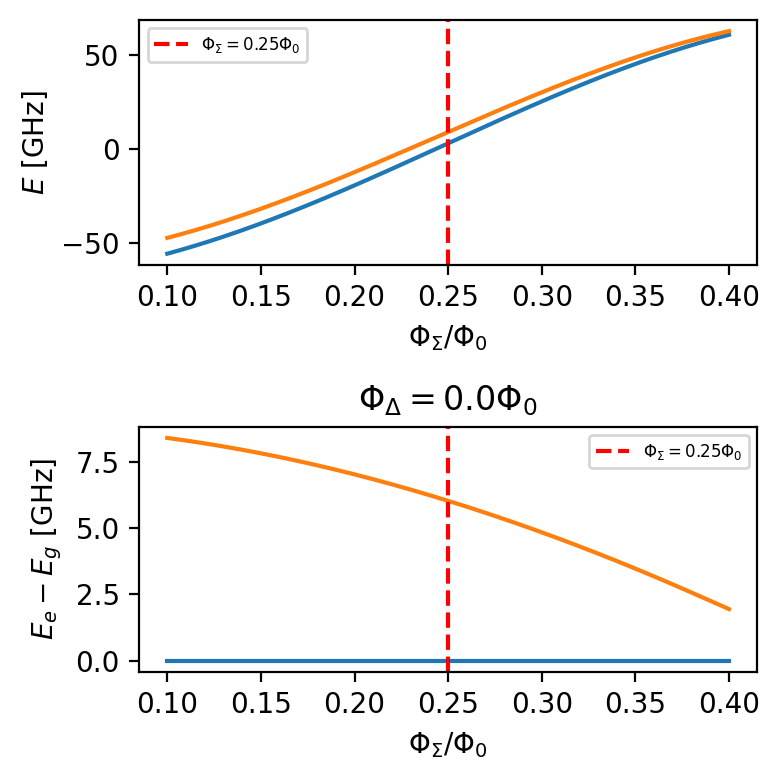

In [94]:
sweep_vals = jnp.linspace(0.1,0.4, 1001)
Es = calc_ats_spectrum_line(ats, sweep_vals, 0.0, sweep_delta=False)[:,:2]
axs = plot_ats_spectrum_line(Es, sweep_vals, sweep_delta=False)

ax = axs[0][0]
ax.axvline(0.25, color="red", linestyle="--", label="$\\Phi_{\\Sigma} = 0.25 \\Phi_{0}$")
ax.legend(fontsize=6)

ax = axs[1][0]
ax.set_title("$\\Phi_{\\Delta} = 0.0\\Phi_0$")
ax.axvline(0.25, color="red", linestyle="--", label="$\\Phi_{\\Sigma} = 0.25 \\Phi_{0}$")
ax.set_ylabel("$E_e - E_g$ [GHz]")
# ax.axvline(0.25, color="r", linestyle="--", label="$\\Phi_{\\Sigma} = 0.25 \\Phi_{0}$")
# ax.set_ylim([5.9,6.1])
ax.legend(fontsize=6)

fig = axs[0][0].get_figure()
fig.tight_layout()

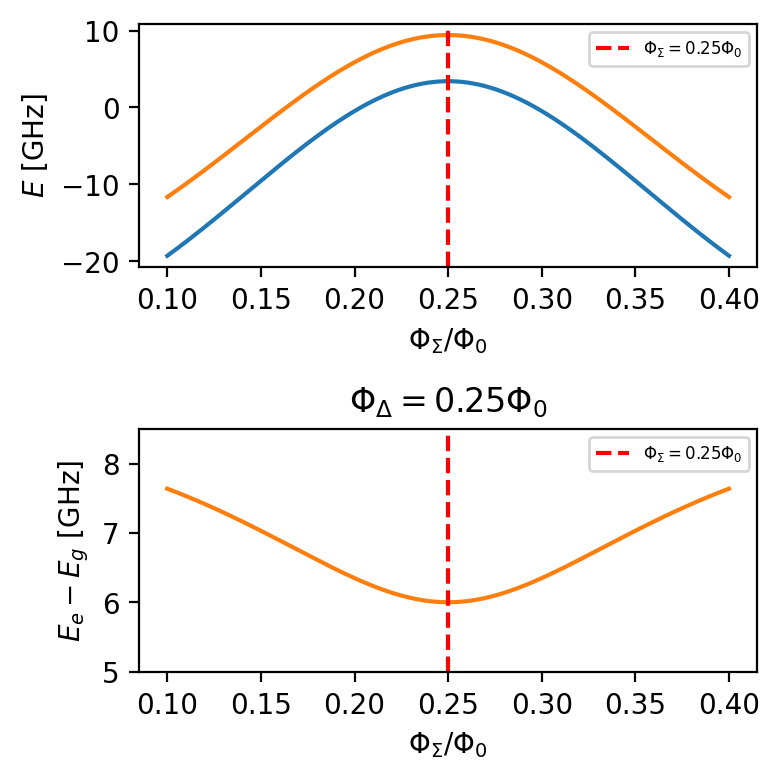

In [93]:
sweep_vals = jnp.linspace(0.1,0.4, 1001)
Es = calc_ats_spectrum_line(ats, sweep_vals, 0.25, sweep_delta=False)[:,:2]
axs = plot_ats_spectrum_line(Es, sweep_vals, sweep_delta=False)

ax = axs[0][0]
ax.axvline(0.25, color="red", linestyle="--", label="$\\Phi_{\\Sigma} = 0.25 \\Phi_{0}$")
ax.legend(fontsize=6)

ax = axs[1][0]
ax.set_title("$\\Phi_{\\Delta} = 0.25\\Phi_0$")
ax.axvline(0.25, color="red", linestyle="--", label="$\\Phi_{\\Sigma} = 0.25 \\Phi_{0}$")
ax.set_ylabel("$E_e - E_g$ [GHz]")
# ax.axvline(0.25, color="r", linestyle="--", label="$\\Phi_{\\Sigma} = 0.25 \\Phi_{0}$")
ax.set_ylim([5,8.5])
ax.legend(fontsize=6)

fig = axs[0][0].get_figure()
fig.tight_layout()

### 2D Plots

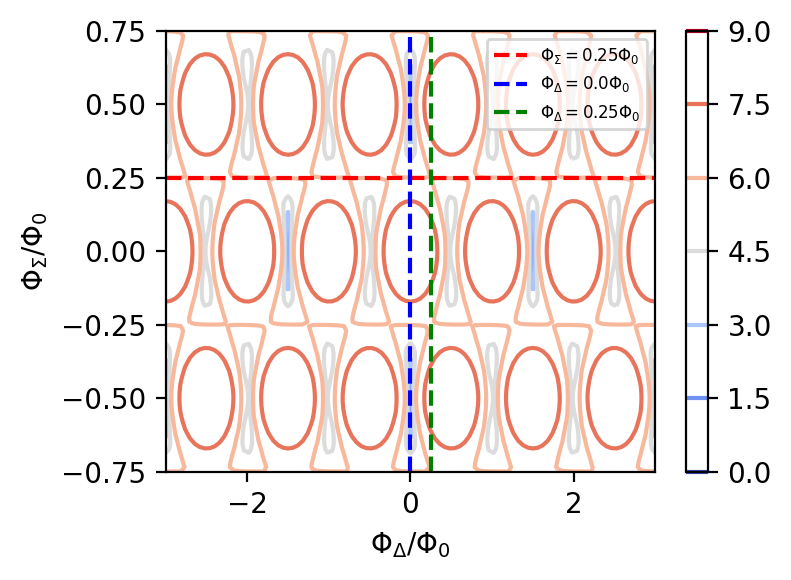

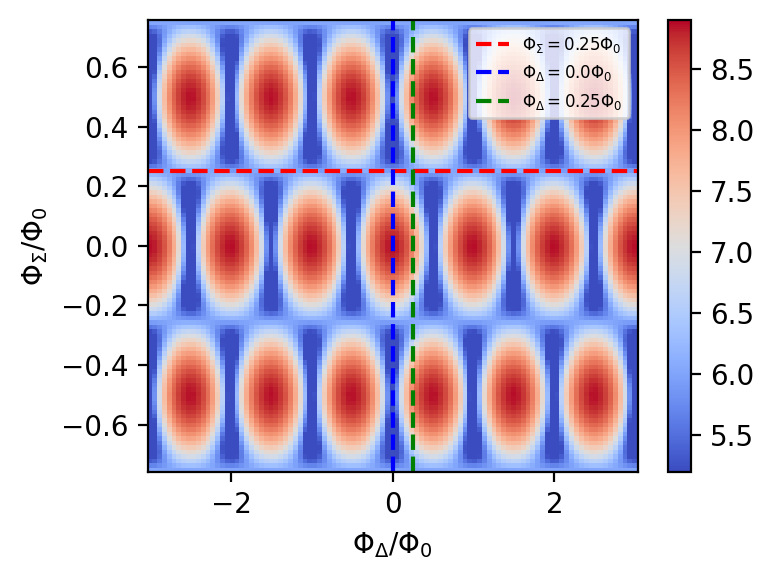

In [95]:
phi_delta_exts = jnp.linspace(-3,3, 101)
phi_sum_exts = jnp.linspace(-0.75,0.75, 101)
xv, yv, Es = calc_ats_spectrum_grid(ats, phi_delta_exts, phi_sum_exts)


axs = plot_ats_spectrum_grid(xv, yv, Es, cmap="coolwarm", ptype="contour")
ax = axs[0][0]
ax.axhline(0.25, label="$\\Phi_{\\Sigma} = 0.25 \\Phi_0$", color="red", linestyle="--")
ax.axvline(0.0, label="$\\Phi_{\\Delta} = 0.0 \\Phi_0$", color="blue", linestyle="--")
ax.axvline(0.25, label="$\\Phi_{\\Delta} = 0.25 \\Phi_0$", color="green", linestyle="--")
ax.legend(fontsize=6)

axs = plot_ats_spectrum_grid(xv, yv, Es, vmin=5.2, vmax=8.9, cmap="coolwarm", ptype="pcolor")
ax = axs[0][0]
ax.axhline(0.25, label="$\\Phi_{\\Sigma} = 0.25 \\Phi_0$", color="red", linestyle="--")
ax.axvline(0.0, label="$\\Phi_{\\Delta} = 0.0 \\Phi_0$", color="blue", linestyle="--")
ax.axvline(0.25, label="$\\Phi_{\\Delta} = 0.25 \\Phi_0$", color="green", linestyle="--")
ax.legend(fontsize=6)

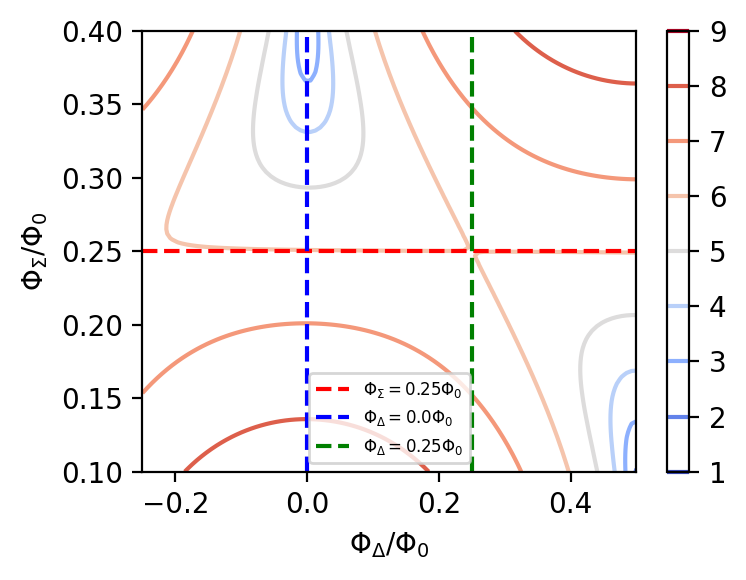

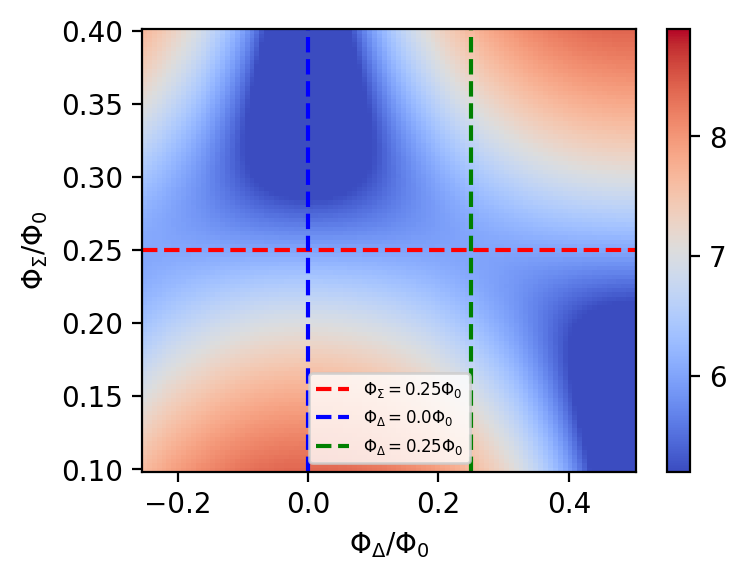

In [96]:
phi_delta_exts = jnp.linspace(-0.25,0.5, 101)
phi_sum_exts = jnp.linspace(0.1,0.4, 101)
xv, yv, Es = calc_ats_spectrum_grid(ats, phi_delta_exts, phi_sum_exts)

axs = plot_ats_spectrum_grid(xv, yv, Es, cmap="coolwarm", ptype="contour")
ax = axs[0][0]
ax.axhline(0.25, label="$\\Phi_{\\Sigma} = 0.25 \\Phi_0$", color="red", linestyle="--")
ax.axvline(0.0, label="$\\Phi_{\\Delta} = 0.0 \\Phi_0$", color="blue", linestyle="--")
ax.axvline(0.25, label="$\\Phi_{\\Delta} = 0.25 \\Phi_0$", color="green", linestyle="--")
ax.legend(fontsize=6)

axs = plot_ats_spectrum_grid(xv, yv, Es, vmin=5.2, vmax=8.9, cmap="coolwarm", ptype="pcolor")
ax = axs[0][0]
ax.axhline(0.25, label="$\\Phi_{\\Sigma} = 0.25 \\Phi_0$", color="red", linestyle="--")
ax.axvline(0.0, label="$\\Phi_{\\Delta} = 0.0 \\Phi_0$", color="blue", linestyle="--")
ax.axvline(0.25, label="$\\Phi_{\\Delta} = 0.25 \\Phi_0$", color="green", linestyle="--")
ax.legend(fontsize=6)